In [1]:
from jitcdde import y, t, input, jitcdde_input
from parameters import *
import numpy as np
from variables import *
from chspy import CubicHermiteSpline
from heat_transfer import *
import pandas as pd
import matplotlib.pyplot as plt
from relaxations import relax_feedback_insertion_beta, relax_all

In [2]:

# external input
def rho_insert(t):
    if (t<t_ins):
        return 0.0
    elif (t<(t_ins+insert_duration)):
        return ((t-t_ins))*(inserted/insert_duration) # linear
    elif (t < t_wd):
        return inserted
    elif (t < t_wd+insert_duration):
        return inserted-((t-t_wd))*(inserted/insert_duration) # linear
    else:
        return 0.0

rho_spline = CubicHermiteSpline(n=1)
rho_spline.from_function(rho_insert, times_of_interest = T)
rho_ext = input(0)


Define system

In [3]:
# CORE
# fuel nodes
dc_f1 = dT_bulkFlow(W_f, m_f_c/2, (hx_fh1_f2(t-tau_hx_c_f)+hx_fh2_f2(t-tau_hx_c_f))/2,c_f1()) + dT_internal(k_f1, P, mcp_f_c, n()) + dT_convective([c_t1()],c_f1(),[hA_ft_c/mcp_f_c]) 
dc_f2 = dT_bulkFlow(W_f, m_f_c/2, c_f1(), c_f2()) +                                             dT_internal(k_f1, P, mcp_f_c, n()) + dT_convective([c_t1()],c_f2(),[hA_ft_c/mcp_f_c]) 

# tubes
dc_t1= dT_convective([c_f1(),c_f2(),c_c1(),c_c2()],c_t1(),[hA_ft_c/mcp_t_c,hA_ft_c/mcp_t_c,hA_tc_c/mcp_t_c,hA_tc_c/mcp_t_c])

# coolant 
dc_c1 = dT_bulkFlow(W_c,m_c_c/2,(hx_ch1_c2(t-tau_hx_c_c)+hx_ch2_c2(t-tau_hx_c_c))/2,c_c1()) + dT_convective([c_t1(),c_m1()],c_c1(),[hA_tc_c/mcp_c_c,hA_mc_c/mcp_c_c]) - arbitrary_removal*c_c1()
dc_c2 = dT_bulkFlow(W_c,m_c_c/2,c_c1(),c_c2()) +                                              dT_convective([c_t1(),c_m1()],c_c2(),[hA_tc_c/mcp_c_c,hA_mc_c/mcp_c_c]) - arbitrary_removal*c_c2()

# moderator 
dc_m =  dT_internal(k_m,P,mcp_m_c,n()) + dT_convective([c_c1(),c_c2()],c_m1(),[hA_mc_c/mcp_m_c,hA_mc_c/mcp_m_c])


In [4]:
# FUEL-HELIUM HX1
dhx_fh1_f1 = dT_bulkFlow(W_f,m_f_hx,c_f2(t-tau_c_hx_f),hx_fh1_f1()) + dT_convective([hx_fh1_t1()],hx_fh1_f1(),[hA_ft_hx/mcp_f_hx]) 
dhx_fh1_f2 = dT_bulkFlow(W_f,m_f_hx,hx_fh1_f1(),hx_fh1_f2()) +        dT_convective([hx_fh1_t1()],hx_fh1_f2(),[hA_ft_hx/mcp_f_hx]) 

# Tubes 
dhx_fh1_t1 = dT_convective([hx_fh1_f1(),hx_fh1_f2(),hx_fh1_h1(),hx_fh1_h2()],hx_fh1_t1(),[h/mcp_t_hx for h in [hA_ft_hx,hA_ft_hx,hA_ht_hx,hA_ht_hx]])

# Helium
dhx_fh1_h1 = dT_bulkFlow(W_h_fh,m_h_hxfh/2,hx_hwf2_h2(t-tau_h),hx_fh1_h1()) + dT_convective([hx_fh1_t1()],hx_fh1_h1(),[hA_ht_hx/mcp_h_hxfh])
dhx_fh1_h2 = dT_bulkFlow(W_h_fh,m_h_hxfh/2,hx_fh1_h1(),hx_fh1_h2()) +         dT_convective([hx_fh1_t1()],hx_fh1_h2(),[hA_ht_hx/mcp_h_hxfh])

# FUEL-HELIUM HX2 Fuel Nodes
dhx_fh2_f1 = dT_bulkFlow(W_f,m_f_hx,c_f2(t-tau_c_hx_f), hx_fh2_f1()) + dT_convective([hx_fh2_t1()],hx_fh2_f1(),[hA_ft_hx/mcp_f_hx])
dhx_fh2_f2 = dT_bulkFlow(W_f,m_f_hx,hx_fh2_f1(),hx_fh2_f2()) +         dT_convective([hx_fh2_t1()],hx_fh2_f2(),[hA_ft_hx/mcp_f_hx])

# Tubes for FUEL-HELIUM HX2
dhx_fh2_t1 = dT_convective([hx_fh2_f1(),hx_fh2_f2(),hx_fh2_h1(),hx_fh2_h2()],hx_fh2_t1(),[h/mcp_t_hx for h in [hA_ft_hx,hA_ft_hx,hA_ht_hx,hA_ht_hx]])

# Helium for FUEL-HELIUM HX2
dhx_fh2_h1 = dT_bulkFlow(W_h_fh,m_h_hxfh/2,hx_hwf1_h2(),hx_fh2_h1()) + dT_convective([hx_fh2_t1()],hx_fh2_h1(),[hA_ht_hx/mcp_h_hxfh])
dhx_fh2_h2 = dT_bulkFlow(W_h_fh,m_h_hxfh/2,hx_fh2_h1(),hx_fh2_h2()) +  dT_convective([hx_fh2_t1()],hx_fh2_h2(),[hA_ht_hx/mcp_h_hxfh])



In [5]:
# COOLANT-HELIUM HX1
# Fuel Nodes
dhx_ch1_c1 = dT_bulkFlow(W_c, m_c_hx, c_c2(t-tau_c_hx_f), hx_ch1_c1()) + dT_convective([hx_ch1_t1()], hx_ch1_c1(), [hA_ct_hx/mcp_c_hxch])
dhx_ch1_c2 = dT_bulkFlow(W_c, m_c_hx, hx_ch1_c1(), hx_ch1_c2()) +        dT_convective([hx_ch1_t1()], hx_ch1_c2(), [hA_ct_hx/mcp_c_hxch])

# Tubes
dhx_ch1_t1 = dT_convective([hx_ch1_c1(),hx_ch1_c2(),hx_ch1_h1(),hx_ch1_h2()],hx_ch1_t1(),[h/mcp_t_hxch for h in [hA_ct_hx,hA_ct_hx,hA_th_hxch,hA_th_hxch]])

# Helium
dhx_ch1_h1 = dT_bulkFlow(W_h_ch, m_h_hxch/2, hx_hwc1_h2(t-tau_h), hx_ch1_h1()) + dT_convective([hx_ch1_t1()], hx_ch1_h1(), [hA_th_hxch/mcp_h_hxch])
dhx_ch1_h2 = dT_bulkFlow(W_h_ch, m_h_hxch/2, hx_ch1_h1(), hx_ch1_h2()) +         dT_convective([hx_ch1_t1()], hx_ch1_h2(), [hA_th_hxch/mcp_h_hxch])

# COOLANT-HELIUM HX2
# Fuel Nodes
dhx_ch2_c1 = dT_bulkFlow(W_c, m_c_hx, c_c2(t-tau_c_hx_f), hx_ch2_c1()) + dT_convective([hx_ch2_t1()], hx_ch2_c1(), [hA_ct_hx/mcp_c_hxch])
dhx_ch2_c2 = dT_bulkFlow(W_c, m_c_hx, hx_ch2_c1(), hx_ch2_c2()) +        dT_convective([hx_ch2_t1()], hx_ch2_c2(), [hA_ct_hx/mcp_c_hxch])

# Tubes
dhx_ch2_t1 = dT_convective([hx_ch2_c1(),hx_ch2_c2(),hx_ch2_h1(),hx_ch2_h2()],hx_ch2_t1(),[h/mcp_t_hxch for h in [hA_ct_hx,hA_ct_hx,hA_th_hxch,hA_th_hxch]])

# Helium
dhx_ch2_h1 = dT_bulkFlow(W_h_ch, m_h_hxch/2, hx_hwc2_h2(t-tau_h), hx_ch2_h1()) + dT_convective([hx_ch2_t1()], hx_ch2_h1(), [hA_th_hxch/mcp_h_hxch])
dhx_ch2_h2 = dT_bulkFlow(W_h_ch, m_h_hxch/2, hx_ch2_h1(), hx_ch2_h2()) +         dT_convective([hx_ch2_t1()], hx_ch2_h2(), [hA_th_hxch/mcp_h_hxch])


In [6]:
# HELIUM-WATER HX1 (FUEL LOOP)
# Helium
dhx_hwf1_h1 = dT_bulkFlow(W_h_fh, m_h_hxhwf/2, hx_fh1_h2(), hx_hwf1_h1()) +  dT_convective([hx_hwf1_t1()], hx_hwf1_h1(), [hA_ht_hxhw/mcp_h_hxhw])
dhx_hwf1_h2 = dT_bulkFlow(W_h_fh, m_h_hxhwf/2, hx_hwf1_h1(), hx_hwf1_h2()) + dT_convective([hx_hwf1_t1()], hx_hwf1_h2(), [hA_ht_hxhw/mcp_h_hxhw])

# Tubes
dhx_hwf1_t1 = dT_convective([hx_hwf1_h1(),hx_hwf1_h2(),hx_hwf1_w1(),hx_hwf1_w2()],hx_hwf1_t1(),[h/mcp_t_hxhw for h in [hA_ht_hxhw,hA_ht_hxhw,hA_tw_hxhw,hA_tw_hxhw]])

# Water
dhx_hwf1_w1 = dT_bulkFlow(W_hhwf_w, m_w_hxhwf/2, T0_hhwf_w1, hx_hwf1_w1()) + dT_convective([hx_hwf1_t1()], hx_hwf1_w1(), [hA_tw_hxhw/mcp_w])
dhx_hwf1_w2 = dT_bulkFlow(W_hhwf_w, m_w_hxhwf/2, hx_hwf1_w1(), hx_hwf1_w2()) + dT_convective([hx_hwf1_t1()], hx_hwf1_w2(), [hA_tw_hxhw/mcp_w])

# HELIUM-WATER HX2 (FUEL LOOP)
# Helium
dhx_hwf2_h1 = dT_bulkFlow(W_h_fh, m_h_hxhwf/2, hx_fh2_h2(), hx_hwf2_h1()) +  dT_convective([hx_hwf2_t1()], hx_hwf2_h1(), [hA_ht_hxhw/mcp_h_hxhw])
dhx_hwf2_h2 = dT_bulkFlow(W_h_fh, m_h_hxhwf/2, hx_hwf2_h1(), hx_hwf2_h2()) + dT_convective([hx_hwf2_t1()], hx_hwf2_h2(), [hA_ht_hxhw/mcp_h_hxhw])

# Tubes
dhx_hwf2_t1 = dT_convective([hx_hwf2_h1(),hx_hwf2_h2(),hx_hwf2_w1(),hx_hwf2_w2()],hx_hwf2_t1(),[h/mcp_t_hxhw for h in [hA_ht_hxhw,hA_ht_hxhw,hA_tw_hxhw,hA_tw_hxhw]])

# Water
dhx_hwf2_w1 = dT_bulkFlow(W_hhwf_w, m_w_hxhwf/2, T0_hhwf_w1, hx_hwf2_w1()) + dT_convective([hx_hwf2_t1()], hx_hwf2_w1(), [hA_tw_hxhw/mcp_w])
dhx_hwf2_w2 = dT_bulkFlow(W_hhwf_w, m_w_hxhwf/2, hx_hwf2_w1(), hx_hwf2_w2()) +                        dT_convective([hx_hwf2_t1()], hx_hwf2_w2(), [hA_tw_hxhw/mcp_w])


In [7]:
# HELIUM-WATER HX1 (COOLANT LOOP)
# Helium
dhx_hwc1_h1 = dT_bulkFlow(W_h_ch, m_h_hxhwc/2, hx_ch1_h2(), hx_hwc1_h1()) + dT_convective([hx_hwc1_t1()], hx_hwc1_h1(), [hA_ht_hxhwc/mcp_h_hxhwc])
dhx_hwc1_h2 = dT_bulkFlow(W_h_ch, m_h_hxhwc/2, hx_hwc1_h1(), hx_hwc1_h2()) + dT_convective([hx_hwc1_t1()], hx_hwc1_h2(), [hA_ht_hxhwc/mcp_h_hxhwc])

# Tubes
dhx_hwc1_t1 = dT_convective([hx_hwc1_h1(),hx_hwc1_h2(),hx_hwc1_w1(),hx_hwc1_w2()],hx_hwc1_t1(),[h/mcp_t_hxhwc for h in [hA_ht_hxhwc,hA_ht_hxhwc,hA_tw_hxhwc,hA_tw_hxhwc]])

# Water
dhx_hwc1_w1 = dT_bulkFlow(W_hhwc_w, m_w_hxhwc/2, T0_hhwc_w1, hx_hwc1_w1()) + dT_convective([hx_hwc1_t1()], hx_hwc1_w1(), [hA_tw_hxhwc/mcp_w_hxhwc])
dhx_hwc1_w2 = dT_bulkFlow(W_hhwc_w, m_w_hxhwc/2, hx_hwc1_w1(), hx_hwc1_w2()) + dT_convective([hx_hwc1_t1()], hx_hwc1_w2(), [hA_tw_hxhwc/mcp_w_hxhwc])


# HELIUM-WATER HX2 (COOLANT LOOP)
# Helium
dhx_hwc2_h1 = dT_bulkFlow(W_h_ch, m_h_hxhwc/2, hx_ch2_h2(), hx_hwc2_h1()) + dT_convective([hx_hwc2_t1()], hx_hwc2_h1(), [hA_ht_hxhwc/mcp_h_hxhwc])
dhx_hwc2_h2 = dT_bulkFlow(W_h_ch, m_h_hxhwc/2, hx_hwc2_h1(), hx_hwc2_h2()) + dT_convective([hx_hwc2_t1()], hx_hwc2_h2(), [hA_ht_hxhwc/mcp_h_hxhwc])

# Tubes
dhx_hwc2_t1 = dT_convective([hx_hwc2_h1(),hx_hwc2_h2(),hx_hwc2_w1(),hx_hwc2_w2()],hx_hwc2_t1(),[h/mcp_t_hxhwc for h in [hA_ht_hxhwc,hA_ht_hxhwc,hA_tw_hxhwc,hA_tw_hxhwc]])

# Water
dhx_hwc2_w1 = dT_bulkFlow(W_hhwc_w, m_w_hxhwc/2, T0_hhwc_w1, hx_hwc2_w1()) + dT_convective([hx_hwc2_t1()], hx_hwc2_w1(), [hA_tw_hxhwc/mcp_w_hxhwc])
dhx_hwc2_w2 = dT_bulkFlow(W_hhwc_w, m_w_hxhwc/2, hx_hwc2_w1(), hx_hwc2_w2()) + dT_convective([hx_hwc2_t1()], hx_hwc2_w2(), [hA_tw_hxhwc/mcp_w_hxhwc])



In [8]:

dn = ((rho()+rho_ext)-beta_t)*n()/Lam+lam[0]*C1()+lam[1]*C2()+lam[2]*C3()+lam[3]*C4()+lam[4]*C5()+lam[5]*C6()           # n (no source insertion): n()

# dC_i/dt (precursor concentrations)
dC1 = n()*beta[0]/Lam - lam[0]*C1() - C1()/tau_c + C1(t-tau_l)*np.exp(-lam[0]*tau_l)/tau_c                       # C1: y(27)
dC2 = n()*beta[1]/Lam - lam[1]*C2() - C2()/tau_c + C2(t-tau_l)*np.exp(-lam[1]*tau_l)/tau_c                       # C2: y(28)
dC3 = n()*beta[2]/Lam - lam[2]*C3() - C3()/tau_c + C3(t-tau_l)*np.exp(-lam[2]*tau_l)/tau_c                       # C3: y(29)
dC4 = n()*beta[3]/Lam - lam[3]*C4() - C4()/tau_c + C4(t-tau_l)*np.exp(-lam[3]*tau_l)/tau_c                       # C4: y(30)
dC5 = n()*beta[4]/Lam - lam[4]*C5() - C5()/tau_c + C5(t-tau_l)*np.exp(-lam[4]*tau_l)/tau_c                       # C5: y(31)
dC6 = n()*beta[5]/Lam - lam[5]*C6() - C6()/tau_c + C6(t-tau_l)*np.exp(-lam[5]*tau_l)/tau_c                       # C6: y(32)

# reactivity 
drho = (a_f/2)*(dc_f1 + dc_f2)+(a_b)*(dc_m)+(a_c/2)*(dc_c1+dc_c2)           # rho: y(33)

In [9]:
# sol = relax_feedback_insertion_beta([a_f,a_b,a_c,inserted,beta_t])
# plt.plot(T,[s[6] for s in sol])

# system = [dc_f1,dc_f2,dc_t1,dc_c1,dc_c2,dc_m,dn,dC1,dC2,dC3,dC4,dC5,dC6,drho,
#                      dhx_fh1_f1,dhx_fh1_f2,dhx_fh1_t1,dhx_fh1_h1,dhx_fh1_h2,
#                      dhx_fh2_f1,dhx_fh2_f2,dhx_fh2_t1,dhx_fh2_h1,dhx_fh2_h2,
#                      dhx_ch1_c1,dhx_ch1_c2,dhx_ch1_t1,dhx_ch1_h1,dhx_ch1_h2,
#                      dhx_ch2_c1,dhx_ch2_c2,dhx_ch2_t1,dhx_ch2_h1,dhx_ch2_h2,
#                      dhx_hwf1_h1,dhx_hwf1_h2,dhx_hwf1_t1,dhx_hwf1_w1,dhx_hwf1_w2,
#                      dhx_hwf2_h1,dhx_hwf2_h2,dhx_hwf2_t1,dhx_hwf2_w1,dhx_hwf2_w2,
#                      dhx_hwc1_h1,dhx_hwc1_h2,dhx_hwc1_t1,dhx_hwc1_w1,dhx_hwc1_w2,
#                      dhx_hwc2_h1,dhx_hwc2_h2,dhx_hwc2_t1,dhx_hwc2_w1,dhx_hwc2_w2,
#                      ]
# for s in system:
#     print(s)

Initial values & solve

In [10]:
# instantiate jitcdde object
DDE = jitcdde_input([dc_f1,dc_f2,dc_t1,dc_c1,dc_c2,dc_m,dn,dC1,dC2,dC3,dC4,dC5,dC6,drho,
                     dhx_fh1_f1,dhx_fh1_f2,dhx_fh1_t1,dhx_fh1_h1,dhx_fh1_h2,
                     dhx_fh2_f1,dhx_fh2_f2,dhx_fh2_t1,dhx_fh2_h1,dhx_fh2_h2,
                     dhx_ch1_c1,dhx_ch1_c2,dhx_ch1_t1,dhx_ch1_h1,dhx_ch1_h2,
                     dhx_ch2_c1,dhx_ch2_c2,dhx_ch2_t1,dhx_ch2_h1,dhx_ch2_h2,
                     dhx_hwf1_h1,dhx_hwf1_h2,dhx_hwf1_t1,dhx_hwf1_w1,dhx_hwf1_w2,
                     dhx_hwf2_h1,dhx_hwf2_h2,dhx_hwf2_t1,dhx_hwf2_w1,dhx_hwf2_w2,
                     dhx_hwc1_h1,dhx_hwc1_h2,dhx_hwc1_t1,dhx_hwc1_w1,dhx_hwc1_w2,
                     dhx_hwc2_h1,dhx_hwc2_h2,dhx_hwc2_t1,dhx_hwc2_w1,dhx_hwc2_w2,
                     ],
                     rho_spline)

# set initial conditions
DDE.constant_past([T0_c_f1,T0_c_f2,T0_c_t1,T0_c_c1,T0_c_c2,T0_c_m+50,n_frac0,C0[0],C0[1],C0[2],C0[3],C0[4],C0[5],0.0,
                   T0_hfh_f1,T0_hfh_f2,T0_hfh_t1,T0_hfh_h1,T0_hfh_h2,
                   T0_hfh_f1,T0_hfh_f2,T0_hfh_t1,T0_hfh_h1,T0_hfh_h2,
                   T0_hch_c1,T0_hch_c2,T0_hch_t1,T0_hch_h1,T0_hch_h2,
                   T0_hch_c1,T0_hch_c2,T0_hch_t1,T0_hch_h1,T0_hch_h2,
                   T0_hhwf_h1,T0_hhwf_h2,T0_hhwf_t1,T0_hhwf_w1,T0_hhwf_w2,
                   T0_hhwf_h1,T0_hhwf_h2,T0_hhwf_t1,T0_hhwf_w1,T0_hhwf_w2,
                   T0_hhwc_h1,T0_hhwc_h2,T0_hhwc_t1,T0_hhwc_w1,T0_hhwc_w2,
                   T0_hhwc_h1,T0_hhwc_h2,T0_hhwc_t1,T0_hhwc_w1,T0_hhwc_w2
                    ])

In [11]:


#DDE.set_integration_parameters(atol=1e-50, rtol=1e-20, first_step=1.0, min_step=1e-11, max_step=10.0, decrease_threshold=1.1, 
#                           increase_threshold=0.5, safety_factor=0.9, max_factor=5.0, min_factor=0.2, pws_factor=3, 
#                           pws_atol=0.0, pws_rtol=1e-05, pws_max_iterations=10, pws_base_increase_chance=0.1, pws_fuzzy_increase=False)
#
# DDE.step_on_discontinuities()
sol_jit = []
for t_x in T:
    sol_jit.append(DDE.integrate(t_x))

Generating, compiling, and loading C code.
Using default integration parameters.


/home/luke/git/envs/thesis_env/lib/python3.11/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.
  warn("You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.")
/home/luke/git/envs/thesis_env/lib/python3.11/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did no

In [12]:
# unpack data
df_power_reversed = pd.read_csv("./data/insertion.csv",header=None)
df_inlet_reversed = pd.read_csv("./data/fuel_inlet_temp.csv",header=None)
df_outlet_reversed = pd.read_csv("./data/fuel_outlet_temp.csv",header=None)
df_power = df_power_reversed.iloc[::-1] 
df_inlet = df_inlet_reversed.iloc[::-1]
df_outlet = df_outlet_reversed.iloc[::-1]
df_power = df_power.reset_index(drop=True)
df_inlet = df_inlet.reset_index(drop=True)
df_outlet = df_outlet.reset_index(drop=True)



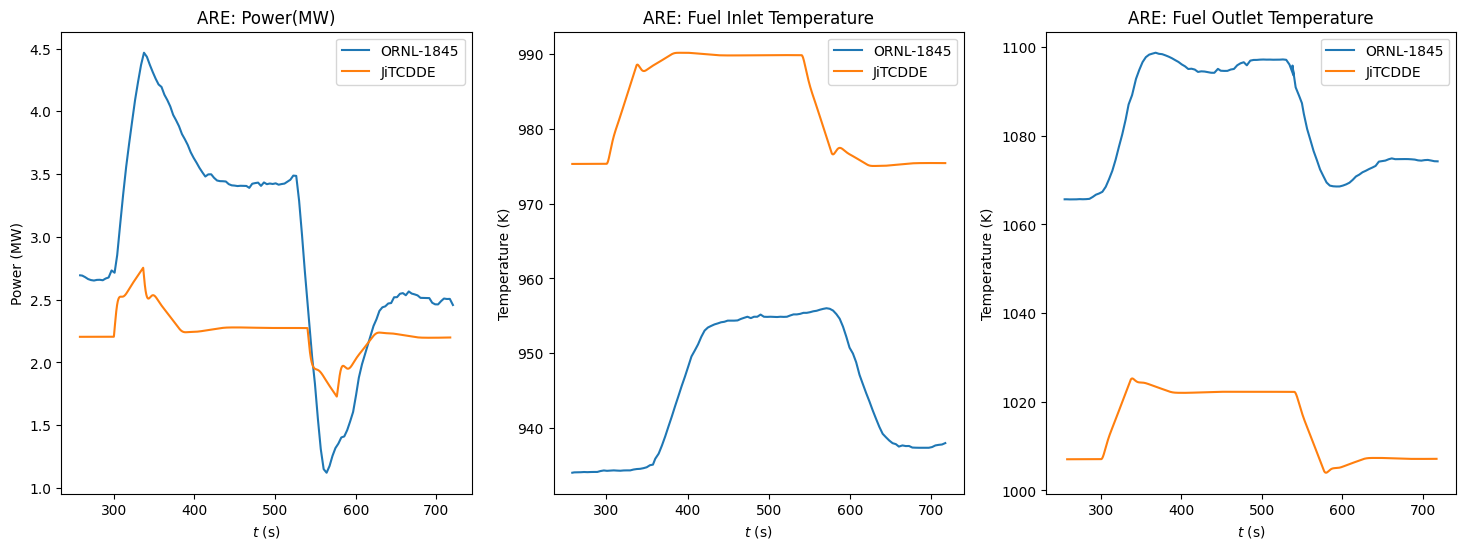

In [13]:

# convert to K
df_inlet[1] = [F_to_K(t) for t in df_inlet[1]]
df_outlet[1] = [F_to_K(t) for t in df_outlet[1]]

# get indices for simulation data
t_before_data = (1110-df_inlet[0][0])*60
duration_data = (df_inlet.iloc[-1][0]-df_inlet[0][0])*60
t_end_data = df_inlet.iloc[-1][0]
t_before_sim = t_ins-t_before_data
T_insert = [t for t in T if (t > (t_before_sim)) and (t < (t_before_sim)+(duration_data))]
i_insert = [t[0] for t in enumerate(T) if (t[1] > (t_before_sim)) and (t[1] < (t_before_sim)+(duration_data))]
adj = (df_inlet[0][0])*60-T_insert[0]


# adjust to reported power
#d = df[1][0]-P
#df[1] = [p-d for p in df[1]]

fig,axs = plt.subplots(1,3,figsize=(18,6))

axs[0].plot(df_power[0]*60-adj,df_power[1],label="ORNL-1845")
axs[0].plot(T_insert,[s[6]*P for s in sol_jit[i_insert[0]:(i_insert[-1]+1)]],label="JiTCDDE")
axs[0].set_xlabel(r"$t$ (s)")
axs[0].set_ylabel("Power (MW)")
axs[0].set_title("ARE: Power(MW)")
axs[0].legend()

axs[1].plot(df_inlet[0]*60-adj,df_inlet[1],label="ORNL-1845")
axs[1].plot(T_insert,[s[0] for s in sol_jit[i_insert[0]:(i_insert[-1]+1)]],label="JiTCDDE")
axs[1].set_xlabel(r"$t$ (s)")
axs[1].set_ylabel("Temperature (K)")
axs[1].set_title("ARE: Fuel Inlet Temperature")
axs[1].legend()

axs[2].plot(df_outlet[0]*60-adj,df_outlet[1],label="ORNL-1845")
axs[2].plot(T_insert,[s[1] for s in sol_jit[i_insert[0]:(i_insert[-1]+1)]],label="JiTCDDE")
axs[2].set_xlabel(r"$t$ (s)")
axs[2].set_ylabel("Temperature (K)")
axs[2].set_title("ARE: Fuel Outlet Temperature")
axs[2].legend()

Generating, compiling, and loading C code.
Using default integration parameters.


/home/luke/git/envs/thesis_env/lib/python3.11/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.
  warn("You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.")


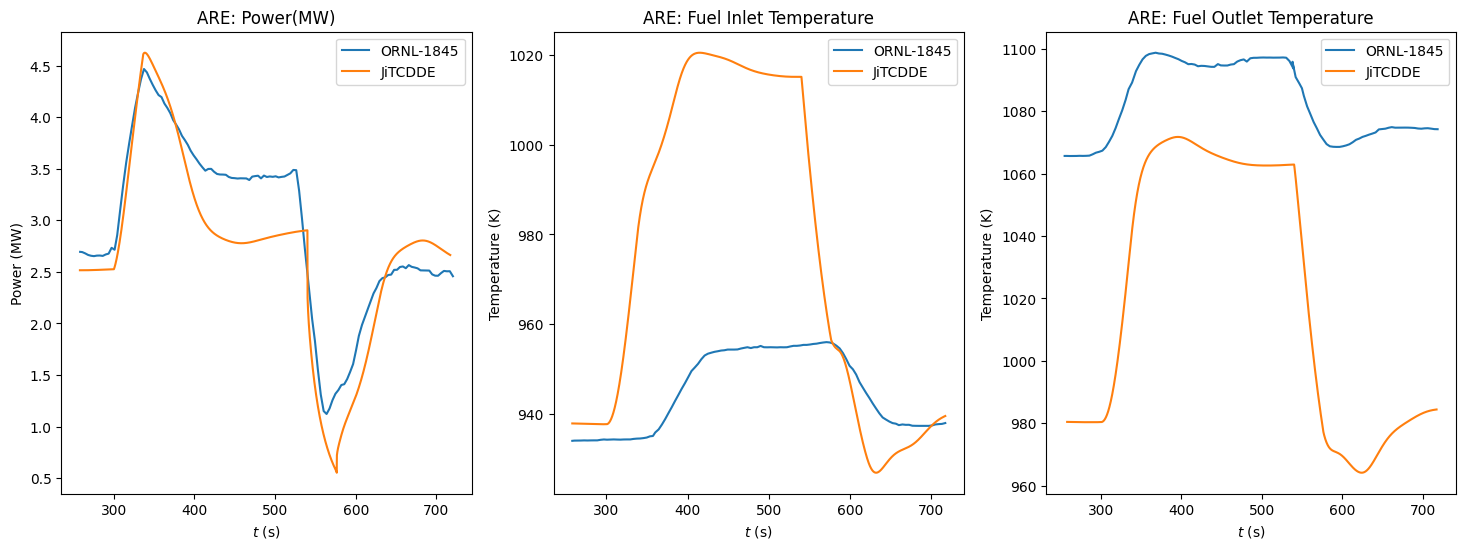

In [14]:
sol_jit = relax_all([-2.86594554e-05,3.73492949e-06, 1.68118283e-05, 1.00264556e-03, 4.92662190e-03,
          3.16511091e+01, 3.04783660e+01, 1.00124536e+01, 3.68708265e+00, 3.96825040e-03,  
          1.00046299e+01, 1.00245969e+00, 2.84221812e-03, 1.58275108e-02, 3.46428214e-02,  
          4.27613016e-04, 9.33258772e-03, 5.75974125e-03, 1.15639862e-03, 1.65871721e-03,
          1.29043763e-02, 2.52389015e-01, 5.45311424e-04, 7.51769201e-02, 1.06779293e-04,  
          9.16034759e-03, 4.96424479e-02, 2.44088251e-01, 1.26052199e-01, 1.81737248e+00,
          6.05885569e-01])

#sol_jit = relax_feedback_insertion_beta([-2.00000000e-04,  4.99999886e-05,  1.47679144e-04,  7.31105685e-03,
#  1.00000000e-03])

fig,axs = plt.subplots(1,3,figsize=(18,6))

axs[0].plot(df_power[0]*60-adj,df_power[1],label="ORNL-1845")
axs[0].plot(T_insert,[s[6]*P for s in sol_jit[i_insert[0]:(i_insert[-1]+1)]],label="JiTCDDE")
axs[0].set_xlabel(r"$t$ (s)")
axs[0].set_ylabel("Power (MW)")
axs[0].set_title("ARE: Power(MW)")
axs[0].legend()

axs[1].plot(df_inlet[0]*60-adj,df_inlet[1],label="ORNL-1845")
axs[1].plot(T_insert,[s[0] for s in sol_jit[i_insert[0]:(i_insert[-1]+1)]],label="JiTCDDE")
axs[1].set_xlabel(r"$t$ (s)")
axs[1].set_ylabel("Temperature (K)")
axs[1].set_title("ARE: Fuel Inlet Temperature")
axs[1].legend()

axs[2].plot(df_outlet[0]*60-adj,df_outlet[1],label="ORNL-1845")
axs[2].plot(T_insert,[s[1] for s in sol_jit[i_insert[0]:(i_insert[-1]+1)]],label="JiTCDDE")
axs[2].set_xlabel(r"$t$ (s)")
axs[2].set_ylabel("Temperature (K)")
axs[2].set_title("ARE: Fuel Outlet Temperature")
axs[2].legend()

In [15]:
t_before_data = (1110-df[0][0])*60
duration_data = (df.iloc[-1][0]-df[0][0])*60

t_end_data = df.iloc[-1][0]
t_before_sim = t_ins-t_before_data

T_insert = [t for t in T if (t > (t_before_sim)) and (t < (t_before_sim)+(duration_data))]
i_insert = [t[0] for t in enumerate(T) if (t[1] > (t_before_sim)) and (t[1] < (t_before_sim)+(duration_data))]

adj = (df[0][0])*60-T_insert[0]
#T_insert = [t-adj for t in T_insert]

plt.plot(df[0]*60-adj,df[1],label='ORNL-1845')
plt.plot(T_insert,[s[6]*P for s in sol_jit][i_insert[0]:(i_insert[-1]+1)],label=r"JiTCDDE") #$\alpha_f'$ = $\frac{\alpha_f}{3.5}$")
plt.legend()
plt.ylabel("Power (MW)")
plt.xlabel("Time(s)")
plt.title("ORNL-1845 vs Simulation")

NameError: name 'df' is not defined

In [ ]:
# write data
output_filename = f"data/insert_out_{T[-1]}_{P}.txt"
results = open(output_filename,'w+')
for k in range(len(i_insert)):
    results.write(f"{T[i_insert[k]]} ")
    for col in range(len(sol_jit[i_insert[k]])):
        results.write(f"{sol_jit[i_insert[k]][col]} ")
    results.write("\n")


In [ ]:
fig,axs = plt.subplots(3,3,figsize=(18,18))

t_0 = 0.0
t_f = 1000

p_error = 0.17

axs[0,0].set_xlim([t_0,t_f])
axs[0,0].plot(T,[s[0] for s in sol_jit],label="core f1") 
axs[0,0].plot(T,[s[1] for s in sol_jit],label="core f2") 
axs[0,0].plot(T,[s[2] for s in sol_jit],label="core t1")  
axs[0,0].plot(T,[s[3] for s in sol_jit],label="core c1")
axs[0,0].plot(T,[s[4] for s in sol_jit],label="core c2")
axs[0,0].plot(T,[s[5] for s in sol_jit],label="core m")
axs[0,0].legend()
axs[0,0].set_title("Core Node Temperatures (K)")
axs[0,0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off


axs[0,1].set_xlim([t_0,t_f])
# axs[0,1].set_ylim([650,750])
axs[0,1].plot(T,[s[6] for s in sol_jit],label="hx_fh f1") 
axs[0,1].plot(T,[s[7] for s in sol_jit],label="hx_fh f2") 
axs[0,1].plot(T,[s[8] for s in sol_jit],label="hx_fh t1")  
axs[0,1].plot(T,[s[9] for s in sol_jit],label="hx_fh h1")
axs[0,1].plot(T,[s[10] for s in sol_jit],label="hx_fh h2")
axs[0,1].plot(T,[s[34] for s in sol_jit],label="hx_fh2 f1") 
axs[0,1].plot(T,[s[35] for s in sol_jit],label="hx_fh2 f2") 
axs[0,1].plot(T,[s[36] for s in sol_jit],label="hx_fh2 t1")  
axs[0,1].plot(T,[s[37] for s in sol_jit],label="hx_fh2 h1")
axs[0,1].plot(T,[s[38] for s in sol_jit],label="hx_fh2 h2")

axs[0,1].legend()
axs[0,1].set_title("HX Fuel->Helium Node Temperatures (K)")
#axs[0,1].tick_params(
#    axis='x',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    top=False,         # ticks along the top edge are off
#    labelbottom=False) # labels along the bottom edge are off

axs[0,2].set_xlim([t_0,t_f])
axs[0,2].plot(T,[s[16] for s in sol_jit],label="hx_hwf h1") 
axs[0,2].plot(T,[s[17] for s in sol_jit],label="hx_hwf h2") 
axs[0,2].plot(T,[s[18] for s in sol_jit],label="hx_hwf t1")  
axs[0,2].plot(T,[s[19] for s in sol_jit],label="hx_hwf w1")
axs[0,2].plot(T,[s[20] for s in sol_jit],label="hx_hwf w2")
axs[0,2].plot(T,[s[44] for s in sol_jit],label="hx_hwf2 h1") 
axs[0,2].plot(T,[s[45] for s in sol_jit],label="hx_hwf2 h2") 
axs[0,2].plot(T,[s[46] for s in sol_jit],label="hx_hwf2 t1")  
axs[0,2].plot(T,[s[47] for s in sol_jit],label="hx_hwf2 w1")
axs[0,2].plot(T,[s[48] for s in sol_jit],label="hx_hwf2 w2")
axs[0,2].legend()
axs[0,2].set_title("HX Helium->Water (Fuel Loop) Node Temperatures (K)")
axs[0,2].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

axs[1,1].set_xlim([t_0,t_f])
axs[1,1].plot(T,[s[11] for s in sol_jit],label="hx_ch f1") 
axs[1,1].plot(T,[s[12] for s in sol_jit],label="hx_ch f2") 
axs[1,1].plot(T,[s[13] for s in sol_jit],label="hx_ch t1")  
axs[1,1].plot(T,[s[14] for s in sol_jit],label="hx_ch h1")
axs[1,1].plot(T,[s[15] for s in sol_jit],label="hx_ch h2")
axs[1,1].plot(T,[s[39] for s in sol_jit],label="hx_ch f1") 
axs[1,1].plot(T,[s[40] for s in sol_jit],label="hx_ch f2") 
axs[1,1].plot(T,[s[41] for s in sol_jit],label="hx_ch t1")  
axs[1,1].plot(T,[s[42] for s in sol_jit],label="hx_ch h1")
axs[1,1].plot(T,[s[43] for s in sol_jit],label="hx_ch h2")
axs[1,1].legend()
axs[1,1].legend()
axs[1,1].set_title("HX Coolant->Helium Node Temperatures (K)")

# fuel temps
axs[1,2].set_xlim([t_0,t_f])
axs[1,2].plot(T,[s[21] for s in sol_jit],label="hx_hwc h1") 
axs[1,2].plot(T,[s[22] for s in sol_jit],label="hx_hwc h2") 
axs[1,2].plot(T,[s[23] for s in sol_jit],label="hx_hwc t1")  
axs[1,2].plot(T,[s[24] for s in sol_jit],label="hx_hwc w1")
axs[1,2].plot(T,[s[25] for s in sol_jit],label="hx_hwc w2")
axs[1,2].plot(T,[s[49] for s in sol_jit],label="hx_hwc h1") 
axs[1,2].plot(T,[s[50] for s in sol_jit],label="hx_hwc h2") 
axs[1,2].plot(T,[s[51] for s in sol_jit],label="hx_hwc t1")  
axs[1,2].plot(T,[s[52] for s in sol_jit],label="hx_hwc w1")
axs[1,2].plot(T,[s[53] for s in sol_jit],label="hx_hwc w2")
axs[1,2].legend()
axs[1,2].set_title("HX Helium->Water (Coolant Loop) Node Temperatures (K)")

axs[1,0].plot(T,[s[6] for s in sol_jit],label="n") 
# axs[1,0].plot(T,[(1+p_error)*s[6] for s in sol_jit],linestyle="--",label="+20%") 
# axs[1,0].plot(T,[(1-p_error)*s[6] for s in sol_jit],linestyle="--",label="-20%") 
axs[1,0].set_xlabel("t (s)")
axs[1,0].set_title(r"$n$")
axs[1,0].set_ylabel(r"$\frac{n}{n_0}$")
axs[1,0].set_xlim([t_0,t_f])
axs[1,0].legend()

axs[2,0].plot(T,[s[13] for s in sol_jit],label="rho") 
axs[2,0].set_xlabel("t (s)")
axs[2,0].set_title(r"$\rho$")
axs[2,0].set_xlim([t_0,t_f])

axs[2,1].plot(T,[s[7] for s in sol_jit],label="C1") 
axs[2,1].plot(T,[s[8] for s in sol_jit],label="C2") 
axs[2,1].plot(T,[s[9] for s in sol_jit],label="C3")  
axs[2,1].plot(T,[s[10] for s in sol_jit],label="C4")
axs[2,1].plot(T,[s[11] for s in sol_jit],label="C5")
axs[2,1].plot(T,[s[12] for s in sol_jit],label="C6")
axs[2,1].legend()
axs[2,1].set_xlabel("t (s)")
axs[2,1].set_yscale("log")
axs[2,1].set_ylabel(r"concentration (1/cm$^3$)")
axs[2,1].legend(loc="right")
axs[2,1].set_title("Precursor Concentrations")
axs[2,1].set_xlim([t_0,t_f])

axs[2,2].plot(T,[s[46]*P for s in sol_jit],label="Power") 
axs[2,2].plot(T,[(1+p_error)*s[46]*P for s in sol_jit],linestyle="--",label="+20%") 
axs[2,2].plot(T,[(1-p_error)*s[46]*P for s in sol_jit],linestyle="--",label="-20%") 
axs[2,2].set_xlabel("t (s)")
axs[2,2].set_title("Power")
axs[2,2].set_ylabel("P (MW)")
axs[2,2].set_xlim([t_0,t_f])



In [ ]:
print((1-p_error)*sol_jit[-1][46])
print(sol_jit[-1][6])
print((1+p_error)*sol_jit[-1][46])
print(sol_jit[-1][53])

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

axs[0].set_xlim([t_0,10])
# axs[0,1].set_ylim([650,750])
axs[0].plot(T,[s[6] for s in sol_jit],label="hx_fh f1") 
axs[0].plot(T,[s[7] for s in sol_jit],label="hx_fh f2") 
axs[0].plot(T,[s[8] for s in sol_jit],label="hx_fh t1")  
axs[0].plot(T,[s[9] for s in sol_jit],label="hx_fh h1")
axs[0].plot(T,[s[10] for s in sol_jit],label="hx_fh h2")
axs[0].plot(T,[s[34] for s in sol_jit],label="hx_fh2 f1") 
axs[0].plot(T,[s[35] for s in sol_jit],label="hx_fh2 f2") 
axs[0].plot(T,[s[36] for s in sol_jit],label="hx_fh2 t1")  
axs[0].plot(T,[s[37] for s in sol_jit],label="hx_fh2 h1")
axs[0].plot(T,[s[38] for s in sol_jit],label="hx_fh2 h2")
axs[0].set_title("HX Fuel->Helium Node Temperatures (K)")
axs[0].legend(loc="right")
axs[0].set_xlabel(r"$t$(s)")

axs[1].set_xlim([t_0,50])
axs[1].plot(T,[s[16] for s in sol_jit],label="hx_hwf h1") 
axs[1].plot(T,[s[17] for s in sol_jit],label="hx_hwf h2") 
axs[1].plot(T,[s[18] for s in sol_jit],label="hx_hwf t1")  
axs[1].plot(T,[s[19] for s in sol_jit],label="hx_hwf w1")
axs[1].plot(T,[s[20] for s in sol_jit],label="hx_hwf w2")
axs[1].plot(T,[s[44] for s in sol_jit],label="hx_hwf2 h1") 
axs[1].plot(T,[s[45] for s in sol_jit],label="hx_hwf2 h2") 
axs[1].plot(T,[s[46] for s in sol_jit],label="hx_hwf2 t1")  
axs[1].plot(T,[s[47] for s in sol_jit],label="hx_hwf2 w1")
axs[1].plot(T,[s[48] for s in sol_jit],label="hx_hwf2 w2")
axs[1].set_title("HX Helium->Water (Fuel Loop) Node Temperatures (K)")
axs[1].legend()
axs[1].set_xlabel(r"$t$(s)")

In [ ]:
# power generation from fission 

# core power generation
pow_f1 = [k_f1*P*s[26] for s in sol_jit]
pow_f2 = [k_f2*P*s[26] for s in sol_jit]
tot_pow = np.add(pow_f1,pow_f2)

# heat extracted by fuel-helium hx
fh_ex = [(s[1]-s[0])*W_scp_f for s in sol_jit]

# heat extracted by coolant-helium hx
ch_ex = [(s[4]-s[3])*W_c*scp_c for s in sol_jit]

# helium-> water (fuel loop)
hwf_ex = [(s[10]-s[9])*W_h_fh*scp_h for s in sol_jit]

# helium-> water (coolant loop)
hwc_ex = [(s[15]-s[14])*W_h_ch*scp_h for s in sol_jit]

tot_ex = [fh_ex[i]+ch_ex[i]+hwf_ex[i]+hwc_ex[i] for i in range(len(sol_jit))]

plt.plot(T,tot_pow,label="core power generation")
plt.plot(T,fh_ex,label="fh hx extraction")
plt.plot(T,ch_ex,label="ch hx extraction")
plt.plot(T,hwf_ex,label="hwf hx extraction")
plt.plot(T,hwc_ex,label="hwc hx extraction")
plt.plot(T,tot_ex,label="total extraction",linestyle="--")
plt.legend()
